In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Engineering
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
# SMOTE
from imblearn.over_sampling import SMOTE
from collections import Counter
# Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
#from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score, f1_score
# Model
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#
import warnings
warnings.filterwarnings("ignore")


# 1. Data Preprocessing

In [31]:
## Read data
filepath = '/content/sample_data/'
df = pd.read_excel(filepath + 'Telco_customer_churn.xlsx')
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

- Convert string column to float
- Rename columns to snake case style

In [32]:
## Rename column
df.columns = [x.lower().replace(' ','_') for x in df.columns]
## Convert string to float
df['total_charges'] = df['total_charges'].replace(' ', np.nan)
df['total_charges'] = df['total_charges'].astype(float)

* Check null value

In [24]:
## Check null value
df.isnull().sum()

customerid              0
count                   0
country                 0
state                   0
city                    0
zip_code                0
lat_long                0
latitude                0
longitude               0
gender                  0
senior_citizen          0
partner                 0
dependents              0
tenure_months           0
phone_service           0
multiple_lines          0
internet_service        0
online_security         0
online_backup           0
device_protection       0
tech_support            0
streaming_tv            0
streaming_movies        0
contract                0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges          11
churn_label             0
churn_value             0
churn_score             0
cltv                    0
churn_reason         5174
dtype: int64

* There are 11 rows missing total_charges value out of 7043 rows. Dropping these rows doesn't effect my model.

In [33]:
df.dropna(subset = ['total_charges'], axis = 0, inplace = True)

In [34]:
df.shape

(7032, 33)

# 2.EDA

## 2.1.Categorical features

- List out distinct values of each categorical feature

In [20]:
details=[]
for col in df.columns[1:]:
    if df[col].dtypes == 'O':
        details.append([col, len(df[col].unique()), df[col].unique()[:5]])
pd.DataFrame(details, columns = ['column', 'n_uniques', 'unique_values'])

,column,n_uniques,unique_values
0,country,1,[United States]
1,state,1,[California]
2,city,833,"[Los Angeles, Beverly Hills, Huntington Park, ..."
3,lat_long,1190,"[33.964131, -118.272783, 34.059281, -118.30742..."
4,gender,2,"[Male, Female]"
5,senior_citizen,2,"[No, Yes]"
6,partner,2,"[No, Yes]"
7,dependents,2,"[No, Yes]"
8,phone_service,2,"[Yes, No]"
9,multiple_lines,3,"[No, Yes, No phone service]"


* We can divide these features into different groups:
  + Customer address: 'country', 'state', 'city', 'zip_code', 'lat_long', 'latitude', 'longitude'
  + Customer demographic:'gender','senior_citizen','partner','dependents'
  + Main services: 'phone_service','multiple_lines','internet_service', 'streaming_tv', 'streaming_movies'
  + Additional services: 'online_security','online_backup','device_protection','tech_support'
  + Contract terms: 'contract', 'paperless_billing', 'payment_method'

  Due to the lack of geographical insights about the specific locations in the US, I will exclude the customer address variables from my analysis and focus on other relevant features.

In [9]:
def plot_stacked_barh(df_cnt, title, ax):
# plot horizontal stacked bar chart
    df_pct = df_cnt/df_cnt.sum().sum()*100

    df_pct.plot.barh(stacked = True, width=0.2, ax = ax)
    for i in range(df_cnt.shape[1]):
        ax.text(y=0,x=df_pct.cumsum(axis = 1).iloc[0,i] - 10,
                 s=f'{df_cnt.iloc[0,i]} \n({np.round(df_pct.iloc[0,i], 1)}%)',
                 color="white",fontsize=6,fontweight="bold")
    ax.legend(loc="upper center", ncol=2, fontsize = 9)
    ax.set_title(title, size = 10)
    ax.set_xlabel('Percentage', size = 8)
    ax.set_yticks([])

def plot_stacked_bar(df, ylabel, ax):
# plot stacked bar chart
    df.plot(kind='bar', stacked=True, colormap='tab10', ax = ax)
    ax.legend(loc="upper right", ncol=2, fontsize = 8, title = ylabel, title_fontsize = 8)
    ax.set_ylabel(ylabel, size = 6)
    ax.set_xlabel("Churn label", size = 6)
    ax.set_title(ylabel + ' and churn', size = 10)
    ax.xaxis.set_tick_params(labelsize=5, labelrotation = False)
    ax.yaxis.set_tick_params(labelsize=5)

    df_prop = df.divide(df.sum(axis=1), axis=0) #proportion
    for n, x in enumerate([*df.index.values]):
        for (proportion, count, y_loc) in zip(df_prop.loc[x],
                                              df.loc[x],
                                              df.loc[x].cumsum()):

            ax.text(y=y_loc - count/2,
                     x=n - 0.15,
                     s=f'{count} ({np.round(proportion * 100, 1)}%)',
                     color="black", fontsize=6, fontweight="bold")

#### Churn label proportion


[]

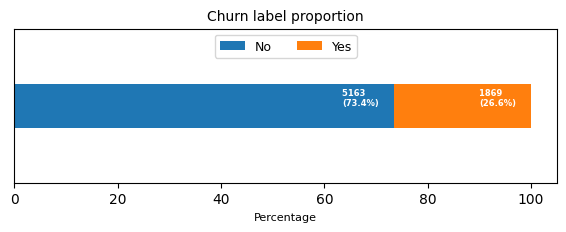

In [35]:
fig, ax = plt.subplots(figsize = (7,2))
churn_cnt = pd.DataFrame(df['churn_label'].value_counts()).T
plot_stacked_barh(churn_cnt, 'Churn label proportion', ax)
plt.plot()

26.6% of customers in the dataset have churned.

#### Churn ratio by customer demographics

- Customer demographics and churn


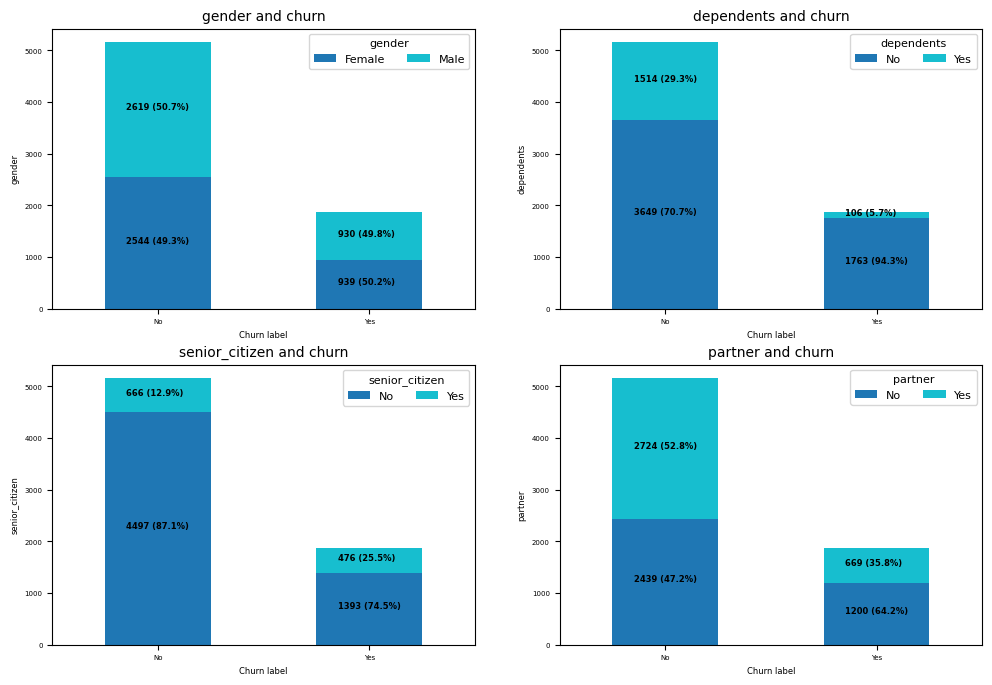

- Senior citizen and Partner proportion


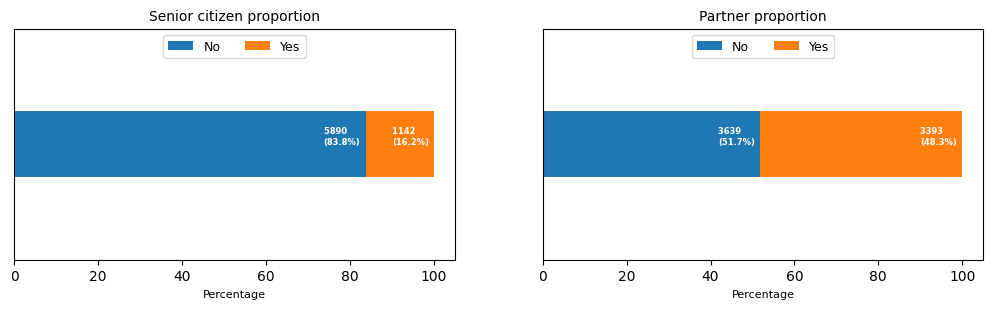

In [36]:
print('- Customer demographics and churn')
cols = ['gender','dependents','senior_citizen','partner']
fig, axes = plt.subplots(2,2,figsize = (12,8))
for ix, col in enumerate(cols):
    df_cnt = pd.crosstab(df['churn_label'], df[col])
    plot_stacked_bar(df_cnt, col, axes.flat[ix])
plt.show()

print('- Senior citizen and Partner proportion')
fig, axes = plt.subplots(1,2,figsize = (12.5,3))
citizen_cnt = pd.DataFrame(df['senior_citizen'].value_counts()).T
plot_stacked_barh(citizen_cnt, 'Senior citizen proportion', axes.flat[0])
partner_cnt = pd.DataFrame(df['partner'].value_counts()).T
plot_stacked_barh(partner_cnt, 'Partner proportion', axes.flat[1])

- Gender does not effect churning. The proportion of Male and Female in
churned and retain groups are roughly equal.
- Customers living with dependents are less likely to churn. Only 5.7% of churned customers have dependents.
- The churn ratio is higher in the senior citizen group compared to the non-senior citizen group. Among 1142 senior citizens, 476 citizens have churned, which is equivalent to 41.7%. In contrast, the churn ratio for the non-senior citizen group is 23.6%.
- Customers who have a partner churn less compared to those who do not have a partner. Among 3402 customers with partners, 669 customers have churned, which is equivalent to 19.6%. This ratio for customers without partners is 32.9%.

#### Churn ratio by Phone service

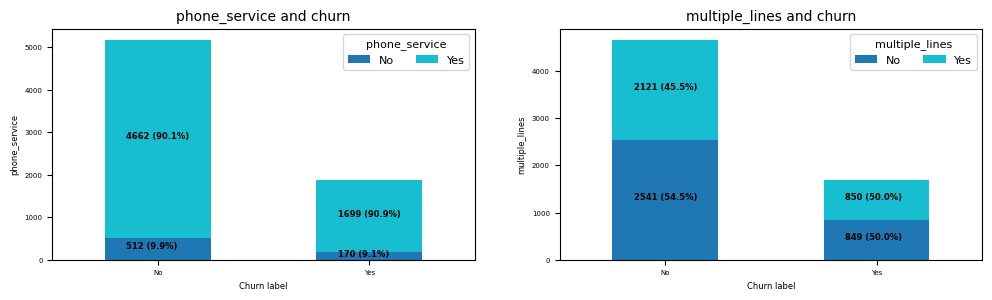

In [39]:
fig, axes = plt.subplots(1,2,figsize = (12,3))
df_cnt = pd.crosstab(df['churn_label'], df['phone_service'])
plot_stacked_bar(df_cnt, 'phone_service', axes.flat[0])

df_cnt = pd.crosstab(df['churn_label'], df['multiple_lines'])
df_cnt.drop(columns = ['No phone service'], inplace = True)
plot_stacked_bar(df_cnt, 'multiple_lines', axes.flat[1])
plt.show()

- There is no singificant effect of using phone service on churn ratio
- In group of customers using phone service, those who use multiplelines have slightly higher churn ratio compared to group not using that service.

#### Churn ratio by Internet service

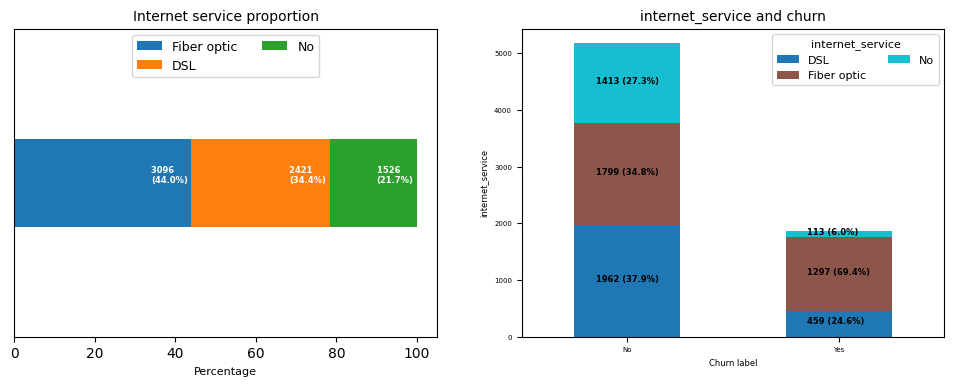

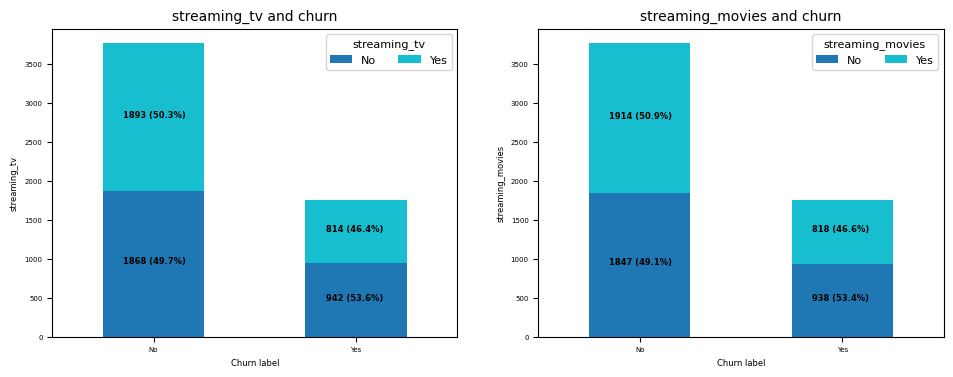

In [41]:
fig, axes = plt.subplots(1,2,figsize = (12,4))
df_cnt = pd.DataFrame(df['internet_service'].value_counts()).T
plot_stacked_barh(df_cnt, 'Internet service proportion', axes[0])
df_cnt = pd.crosstab(df['churn_label'], df['internet_service'])
plot_stacked_bar(df_cnt, 'internet_service', axes.flat[1])
plt.plot()

cols = ['streaming_tv','streaming_movies']
fig, axes = plt.subplots(1,2,figsize = (11.5,4))
for ix, col in enumerate(cols):
    df_cnt = pd.crosstab(df['churn_label'], df[col])
    df_cnt.drop(columns = ['No internet service'], inplace = True)
    plot_stacked_bar(df_cnt, col, axes.flat[ix])
plt.show()

- 21.7% of customers do not use internet service. Among those who use internet service, 56% use Fiber optic (equivalent to 44% of total customers), 44% use DSL (equivalent to 34.4% of total customers).
- Customers using Fiber optic have the highest churn ratio, accounting for 69.4% of churned customers, followed by the group using DSL, which accounts for 24.6% of churned customers. Only 6% of churned customers do not use internet service.
- In the group of customers using internet service, those who use streaming TV or streaming movies have a slightly lower churn rate compared to those who do not use streaming TV/streaming movies.

In [25]:
df.groupby(['churn_label','phone_service','internet_service']).size()


churn_label  phone_service  internet_service
No           No             DSL                  512
             Yes            DSL                 1450
                            Fiber optic         1799
                            No                  1413
Yes          No             DSL                  170
             Yes            DSL                  289
                            Fiber optic         1297
                            No                   113
dtype: int64

#### Churn ratio by additional services

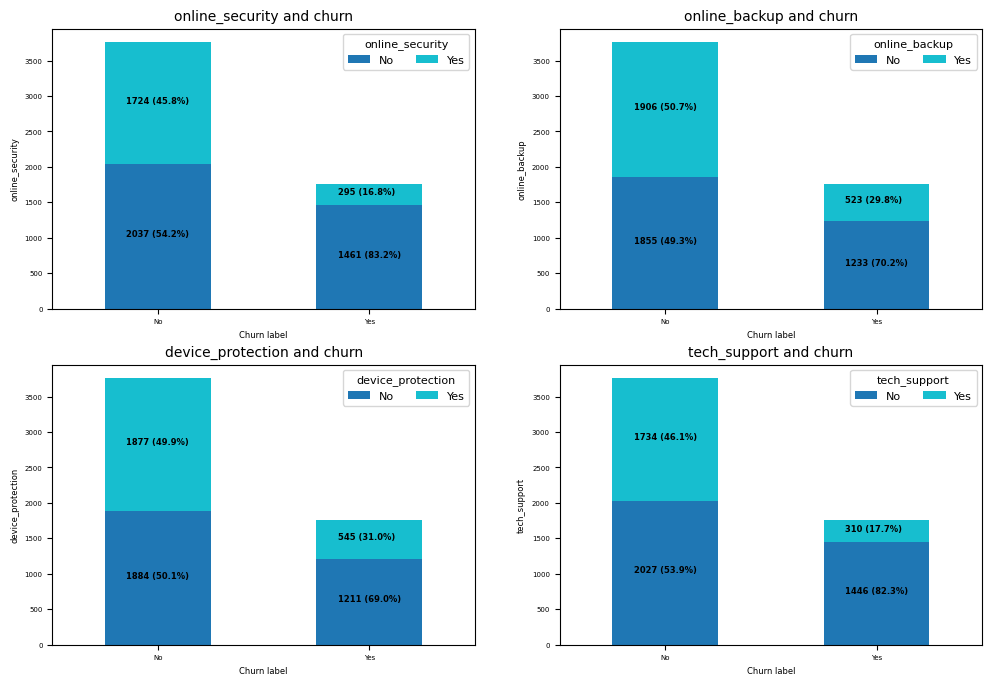

In [42]:
cols = ['online_security', 'online_backup', 'device_protection', 'tech_support']
fig, axes = plt.subplots(2,2,figsize = (12,8))
for ix, col in enumerate(cols):
    df_cnt = pd.crosstab(df['churn_label'], df[col])
    df_cnt.drop(columns = ['No internet service'], inplace = True)
    plot_stacked_bar(df_cnt, col, axes.flat[ix])
plt.show()

- Four charts above prove that those who do not use additional services including online_security, online_backup, device_protection, tech_support have significantly higher churn ratio compared to the group of customer using these services.

#### Churn ratio by contract term

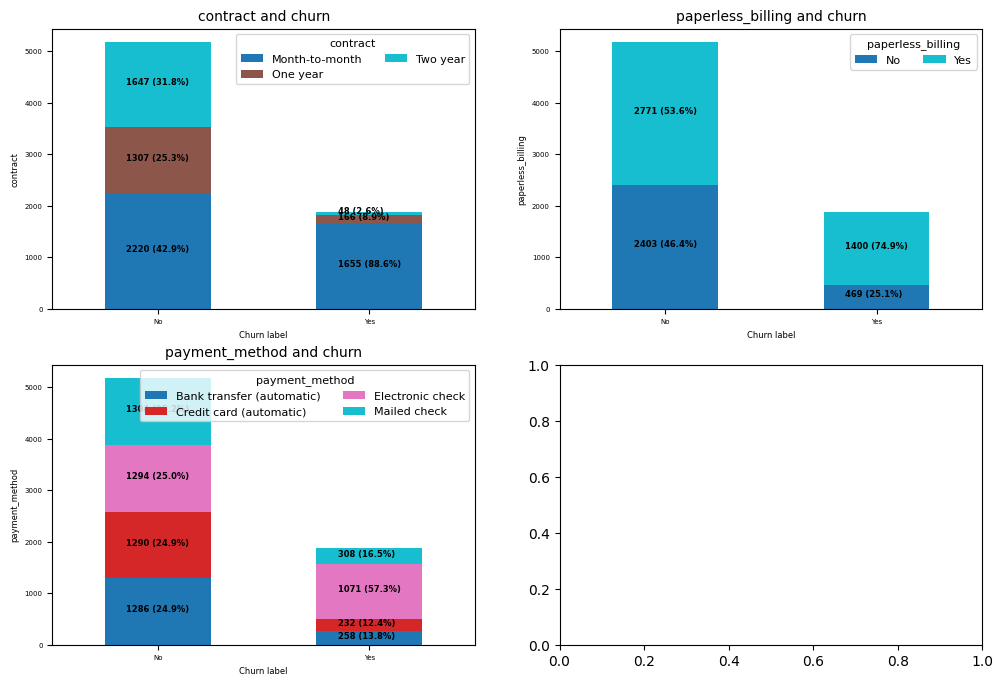

In [43]:
cols = ['contract', 'paperless_billing', 'payment_method']
fig, axes = plt.subplots(2,2,figsize = (12,8))
for ix, col in enumerate(cols):
    df_cnt = pd.crosstab(df['churn_label'], df[col])
    plot_stacked_bar(df_cnt, col, axes.flat[ix])
plt.show()

- The majority of churned customers use a Month-to-Month contract, accounting for 88.6% of churned customers.
- Those who not use paperless billing have higher churn ratio, accounting for 74.9% of churned customers, while 25% of the churned group uses paperless billing.
- Those who using electronic payment method have highest churn ratio, account for 57,3% of churned group, while those who use other payment method account for a range of 12-16% of churned customers.

## 2.2.Numerical features

The dataset consists three numerical features: tenure(month), monthly charges, and total charges. I plot and compare the histogram of each feature for churn and retain group.

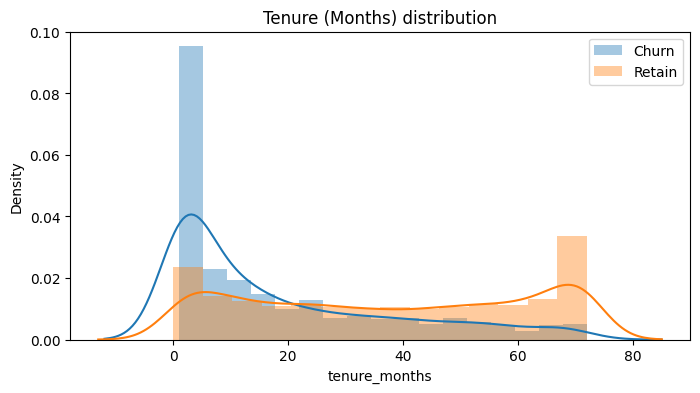

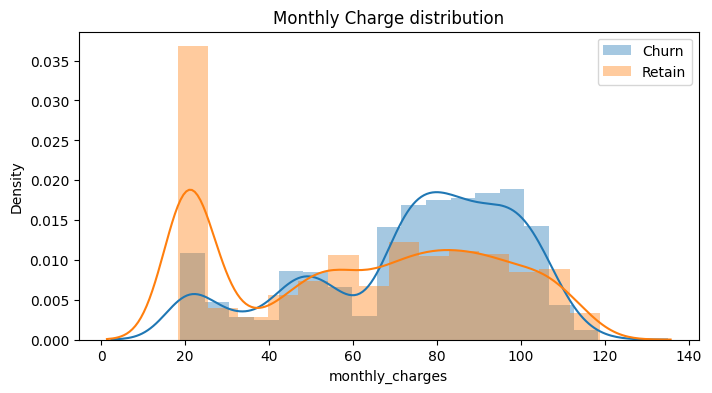

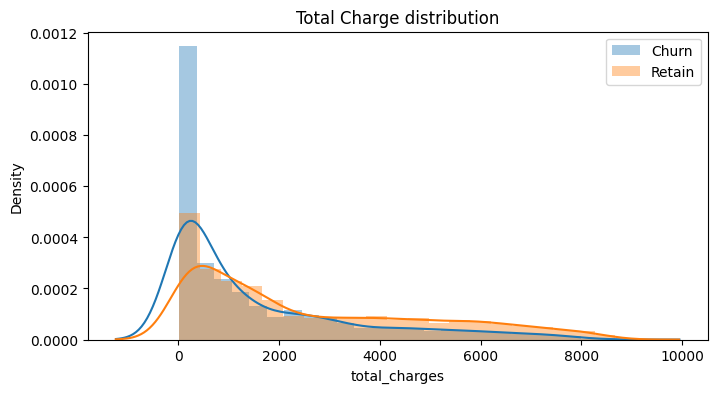

In [50]:
plt.figure(figsize = (8,4))
plt.title('Tenure (Months) distribution')
sns.distplot(df[df['churn_label'] == 'Yes']['tenure_months'], label='Churn')
sns.distplot(df[df['churn_label'] == 'No']['tenure_months'], label='Retain')
plt.legend(loc= 'upper right')
plt.show()

plt.figure(figsize = (8,4))
plt.title('Monthly Charge distribution')
sns.distplot(df[df['churn_label'] == 'Yes']['monthly_charges'], label='Churn')
sns.distplot(df[df['churn_label'] == 'No']['monthly_charges'], label='Retain')
plt.legend(loc= 'upper right')
plt.show()

plt.figure(figsize = (8,4))
plt.title('Total Charge distribution')
sns.distplot(df[df['churn_label'] == 'Yes']['total_charges'], label='Churn')
sns.distplot(df[df['churn_label'] == 'No']['total_charges'], label='Retain')
plt.legend(loc= 'upper right')
plt.show()

In [37]:
counts, bin_edges = np.histogram(df['total_charges'])
counts, bin_edges
#df['total_charges'].isnull().sum()
#df['total_charges']

(array([2709, 1228,  671,  508,  454,  412,  395,  310,  223,  122]),
 array([  18.8,  885.4, 1752. , 2618.6, 3485.2, 4351.8, 5218.4, 6085. ,
        6951.6, 7818.2, 8684.8]))

- The longer tenure month contract, the churn probability decreases.
- Customers using tenure contract less than 30 months have significantly higher churn ratio compared to those using longer contract.
- Customers who pay more than 65 per month have a higher chance of churning compared to the group that pays less than 65 per month.
- The more customers paid for company, the less they will churn. The highest churn ratio is observed in the group that pays less than $1000.

## 2.3. The senior citizen group

Let dig deeper into the senior citizen group which has high churn ratio of 41.7%.

In [40]:
df_senior = df[df.senior_citizen == 'Yes']
df_senior.shape

(1142, 33)

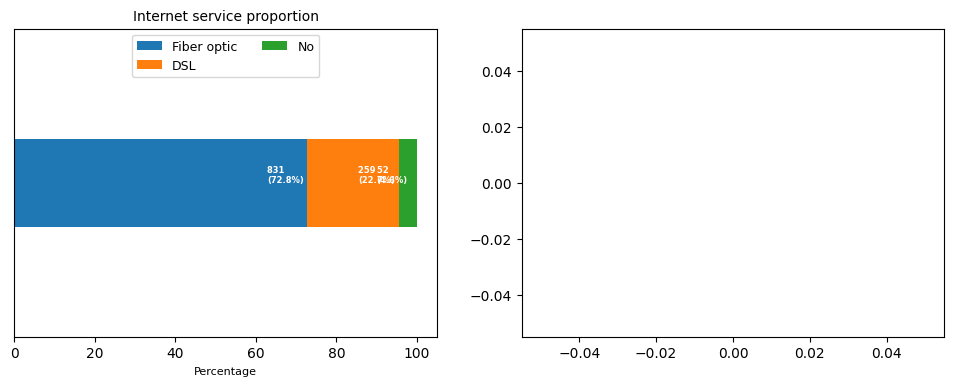

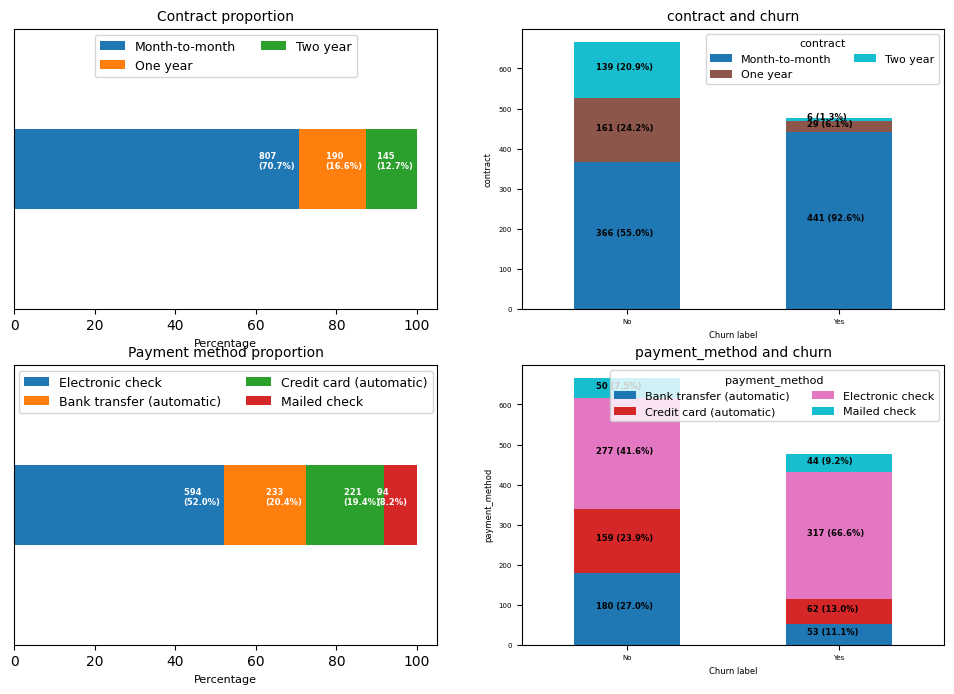

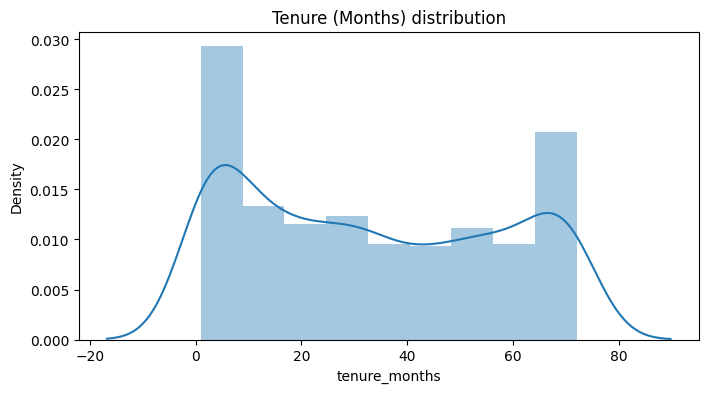

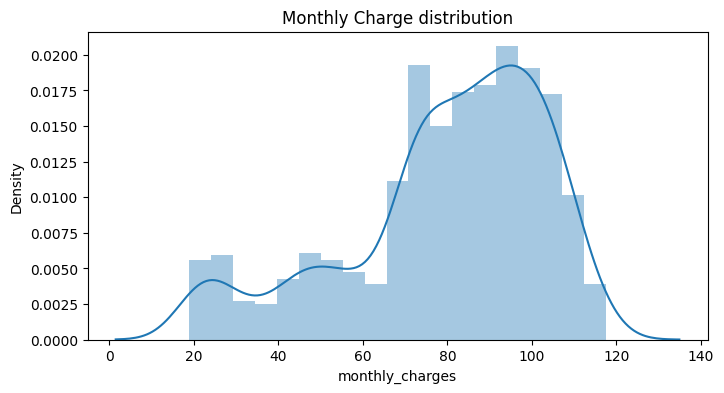

In [56]:
fig, axes = plt.subplots(1,2,figsize = (12,4))
df_cnt = pd.DataFrame(df_senior['internet_service'].value_counts()).T
plot_stacked_barh(df_cnt, 'Internet service proportion', axes[0])
print()
plt.plot()

fig, axes = plt.subplots(2,2,figsize = (12,8))
df_cnt = pd.DataFrame(df_senior['contract'].value_counts()).T
plot_stacked_barh(df_cnt, 'Contract proportion', axes.flat[0])
df_cnt = pd.crosstab(df_senior['churn_label'], df['contract'])
plot_stacked_bar(df_cnt, 'contract', axes.flat[1])
plt.plot()

df_cnt = pd.DataFrame(df_senior['payment_method'].value_counts()).T
plot_stacked_barh(df_cnt, 'Payment method proportion', axes.flat[2])
df_cnt = pd.crosstab(df_senior['churn_label'], df['payment_method'])
plot_stacked_bar(df_cnt, 'payment_method', axes.flat[3])
plt.plot()

plt.figure(figsize = (8,4))
plt.title('Tenure (Months) distribution')
sns.distplot(df_senior['tenure_months'])
plt.show()

plt.figure(figsize = (8,4))
plt.title('Monthly Charge distribution')
sns.distplot(df_senior['monthly_charges'])
plt.show()

The elder group have typical characteristics of a churned customer:
- 71.8% of senior citizen using Fiber optic internet service, with the churn ratio of 47.2%.
- 70.7% of them sign short-term month-to-month contract.
- 52% of them useing electronic check.
- The majority of senior citizens have contracts with a monthly cost exceeding $65.

## 2.4. Summary of EDA


The portrait of churned customers:
- Single customer: 93.3% of churned customers not living with dependents, 64.2% of them not living with partner.
- Senior citizen group: 41.7% of senior citizen customers have churned, which is as twice as the ratio of non-senior group.
- Using Fiber internet service: Among customers using internet service, those using Fiber have highest churn ratio, account for 69.4% of churned customers.
- Using short-term contract: 88.6% of churned customers using month-to-month contract.
- Using electronic payment method: Those who use electronic payment method have highest churn ratio, account for 57,3% of churned group.
- Higher churn in the group signs 1-5 months contract, pays more than 65 dollar per month, and paid less than 1000 in total.

The evidences of customers retention:
  - Those who use additional services, paperless billing show signigicantly less churning rate compared to group not using these servies.
  - Customers using streaming tv and movies are less churned compared to these not using them.

Therefore, to decrease the churn ratio, Telco should:
  - Promote dependents, partner option for customers. Encourage customers using additional services and using paperless method to make payment.
  - Improve products and services for the elder.
  - Improve electronic payment processes.
  - Promote long-term contracts with a medium amount charge of 40-65 dollars per month.


# 3.Modelling


## 3.1. Feature Engineering

* Remove meaningless features
* Labeling categorical features
* Scaling numerical features.

In [35]:
cols_to_remove = ['count','customerid', 'churn_value', 'churn_score', 'cltv', 'churn_reason'
                 , 'country', 'state', 'city', 'lat_long', 'zip_code', 'latitude','longitude']
cols_remain = [x for x in df.columns if x not in cols_to_remove]
cols_cat, cols_num = [], []
for col in cols_remain:
    if df[col].dtypes == 'O': cols_cat.append(col)
    else: cols_num.append(col)

# Apply Scaler
#scaler = MinMaxScaler()
#df_num_norm = pd.DataFrame(scaler.fit_transform(df[cols_num]), columns = cols_num)
scaler = StandardScaler()
df_num = pd.DataFrame(scaler.fit_transform(df[cols_num]), columns = cols_num)

# Apply label encode
label_encoder = LabelEncoder()
df_cat = df[cols_cat].apply(label_encoder.fit_transform)

* There is an imbalanced proportion of labels in the dataset, with only 25% of customers have churned. Therefore, I apply SMOTE to oversampling the minority class.

In [36]:
X = pd.concat([df_cat, df_num_stand], axis=1)
X.dropna(axis = 0, inplace = True)
y = X['churn_label']
X.drop(columns = ['churn_label'], inplace = True)
X = X.values
over = SMOTE(sampling_strategy = 1)
X, y = over.fit_resample(X, y)
X.shape, y.shape

((10348, 18), (10348,))

In [31]:
Counter(y)

Counter({1: 5174, 0: 5174})

## 3.2. Build models

Three classification models are applied to the dataset: Logistic regression, XGBoost Classifier,  and Random Forest Classifier.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 2)

models = []
models.append(('LogisticRegression',LogisticRegression()) )
models.append(('XGBClassifier',XGBClassifier(learning_rate= 0.01,max_depth = 3,n_estimators = 1000)) )
models.append(('RandomForestClassifier', RandomForestClassifier(max_depth = 4,random_state = 0)) )
model_results = []
name, classifier  = models[0]

for name, classifier in models:
    ## Train model
    classifier.fit(X_train,y_train)
    prediction = classifier.predict(X_test)
    # Using k-fold cross-validation:
    cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 1)
    ## Evaluation metrics
    cross_val = round(cross_val_score(classifier,X_train,y_train,cv = cv,scoring = 'roc_auc').mean(), 2)
    cross_val_recall = round(cross_val_score(classifier,X_train,y_train,cv = cv,scoring = 'recall').mean(), 2)
    precision = precision_score(y_test, classifier.predict(X_test))
    recall = recall_score(y_test, classifier.predict(X_test))
    f1 = f1_score(y_test, classifier.predict(X_test))
    roc_auc = roc_auc_score(y_test,prediction)
    model_results.append([name, precision, recall, f1, cross_val, cross_val_recall, roc_auc])


## 3.3. Model Validation

I generate several metrics to evaluate the performance of these models:
* Precision: The accuracy of churned label predictions
* Recall: The ability of a model to correctly identify all churned label
* F1: Combining precision and recall. It provides a balanced measure of the model's performance by considering both the ability to make accurate churned label predictions (precision) and the ability to identify all positive churn. cases (recall)
* ROC_AUC: The are under the plot of the true positive rate (sensitivity) against the false positive rate (1 - specificity) at various classification thresholds.
* Cross validation (ROC_AUC): Dividing the dataset into 10 subsets, training the model on some subsets, and then getting the average of ROC AUC metric.
* Cross validation (Recall): Dividing the dataset into 10 subsets, training the model on some subsets, and then getting the average of Recall metric.

For churn prediction, correctly identifying all customers who have churned may be the most important. Therefore, we should pay more attention to F1 and Recall scores.
Three models result very good performance with cross validation score (ROC_AUC) above 87%, cross validation score (Recall) above 82%. Luckily, XGBoost Classifier is outperformed in terms of all of the metrics.

In [50]:
pd.DataFrame(model_results, columns = ['Name', 'Precision', 'Recall', 'F1', 'Cross validation (ROC_AUC)', 'Cross validation (Recall)', 'AUC'])

,Name,Precision,Recall,F1,Cross validation (ROC_AUC),Cross validation (Recall),AUC
0,LogisticRegression,0.749561,0.835455,0.790181,0.87,0.82,0.781884
1,XGBClassifier,0.811388,0.893242,0.850350,0.93,0.88,0.845572
2,RandomForestClassifier,0.761905,0.861900,0.808824,0.88,0.84,0.799873


# 4. Conclusion

* The exploratory data analysis (EDA) process revealed several common characteristics of churned customers, such as living alone, belonging to the senior citizen group, having short-term contracts, and paying higher monthly charges. Additionally, evidence suggests that customers using Fiber internet service and electronic payment methods have higher churn ratios.
* Three classification models were applied to the dataset, and the XGBoost Classifier demonstrated the best performance with a cross-validation score of 88%.
* To further enhance the analysis, it is recommended to incorporate additional features, such as:
  * Customer interactions: call logs, email communications, and customer feedback.
  * Recency and frequency of customer activities
  * Demographic information like credit score, income, and household size, would provide valuable insights.
